In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Fun for getting avg hue and check work of color correction
def avgHue(image):
  R, G, B = cv2.split(image)
  return [np.mean(R).astype(np.uint8), np.mean(G).astype(np.uint8), np.mean(B).astype(np.uint8)]

In [4]:
# Correction with reference color
def colorCorrection(image, Rdst, Gdst, Bdst):

    R, G, B = cv2.split(image)

    # Correction with reference color
    R_corrected = R * (Rdst / np.mean(R))
    G_corrected = G * (Gdst / np.mean(G))
    B_corrected = B * (Bdst / np.mean(B))

    # Normalizing to [0,255] and backing to Int
    corrected_image = cv2.merge([R_corrected, G_corrected, B_corrected])
    corrected_image = np.clip(corrected_image, 0, 255).astype(np.uint8)

    return corrected_image

Source image avgHue: [183, 152, 209]
Corrected image avgHue: [152, 149, 199]


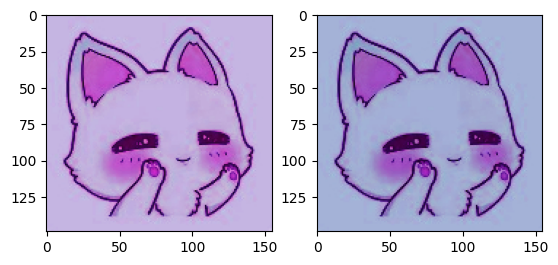

In [8]:
# Demonstration of correction with reference color
image = cv2.imread('/content/sample_data/cat.jpg', cv2.IMREAD_COLOR)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

print("Source image avgHue:",avgHue(image))
print("Corrected image avgHue:",avgHue(colorCorrection(image, 153, 150, 200)))

plt.subplot(1,2,1)
plt.imshow(image)
plt.subplot(1,2,2)
plt.imshow(colorCorrection(image, 153, 150, 200))
plt.show()

In [9]:
# Gray world realization
def grayWorld(image):
  R,G,B = cv2.split(image)
  avgR = np.mean(R)
  avgG = np.mean(G)
  avgB = np.mean(B)

  AVG = (avgR + avgG + avgB)/3

  image = cv2.merge([R*(AVG/avgR), G*(AVG/avgG), B*(AVG/avgB)])
  image = np.clip(image, 0, 255).astype(np.uint8)
  return image

Avg hue of gray world: [181, 181, 181]
Max red of gray world:: 224
Max green of gray world:: 198
Max blue of gray world:: 234


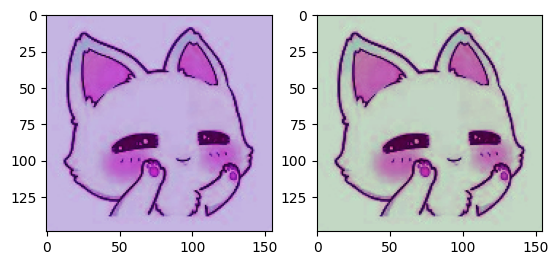

In [12]:
# Demonstration of gray world realization
image = cv2.imread('/content/sample_data/cat.jpg', cv2.IMREAD_COLOR)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

print("Avg hue of gray world:", avgHue(grayWorld(image)))
print("Max red of gray world::",np.max(image[:,:,0]))
print("Max green of gray world::",np.max(image[:,:,1]))
print("Max blue of gray world::",np.max(image[:,:,2]))
plt.subplot(1,2,1)
plt.imshow(image)
plt.subplot(1,2,2)
plt.imshow(grayWorld(image))
plt.show()

In [17]:
# Function correction
# Linear correction: y = kx + b
def linear_correction(image, k, b):

    # Created same shape empty image
    corrected_image = np.zeros_like(image, dtype=np.uint8)

    # Linear correction
    for channel in range(image.shape[2]):
        corrected_channel = k * image[:, :, channel] + b
        corrected_image[:, :, channel] = np.clip(corrected_channel, 0, 255).astype(np.uint8)
    return corrected_image

Source image avgHue: [183, 152, 209]
Corrected image avgHue: [241, 219, 245]


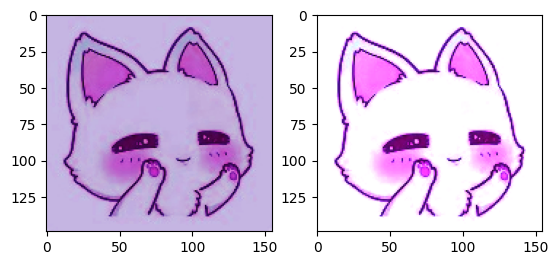

In [18]:
# Demonstration of linear correction
image = cv2.imread('/content/sample_data/cat.jpg', cv2.IMREAD_COLOR)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

print("Source image avgHue:" ,avgHue(image))
print("Corrected image avgHue:",avgHue(linear_correction(image, 1.5, 0)))

plt.subplot(1,2,1)
plt.imshow(image)
plt.subplot(1,2,2)
plt.imshow(linear_correction(image, 1.5, 0))
plt.show()

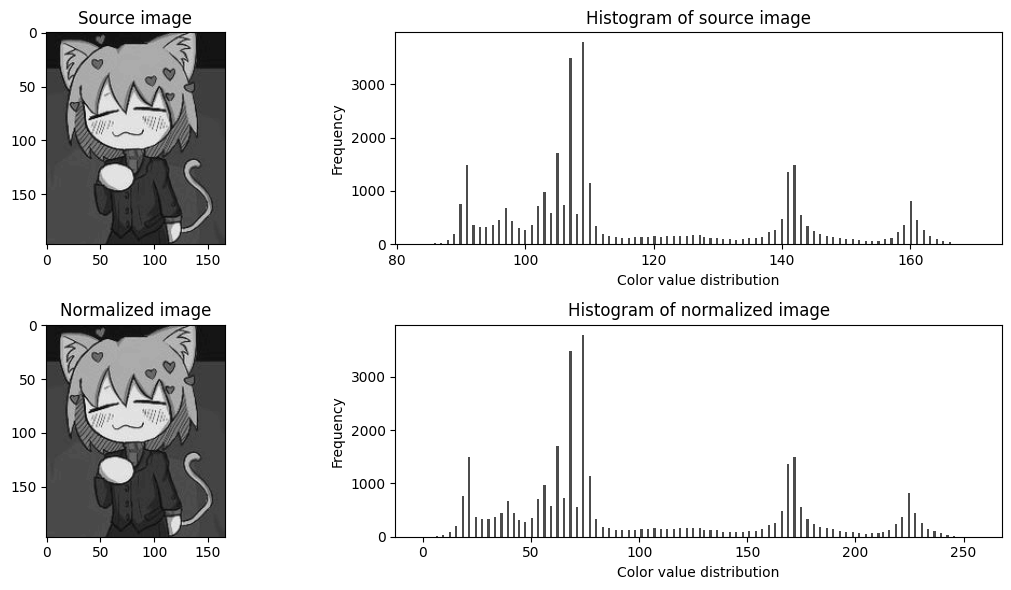

In [21]:
# Histogram Normalization
image = cv2.imread("/content/sample_data/cat_norm.jpg", cv2.IMREAD_GRAYSCALE)

normalized_image = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX) # maybe need own realization

# Plots
plt.figure(figsize=(12, 6))

plt.subplot(2, 2, 1)
plt.imshow(image,'gray')
plt.title('Source image')
plt.subplot(2, 2, 2)
plt.hist(image.ravel(), bins=256, color='black', alpha=0.7)
plt.xlabel('Color value distribution')
plt.ylabel('Frequency')
plt.title('Histogram of source image')

plt.subplot(2, 2, 3)
plt.imshow(normalized_image, 'gray')
plt.title('Normalized image')
plt.subplot(2, 2, 4)
plt.hist(normalized_image.ravel(), bins=256, color='black', alpha=0.7)
plt.xlabel('Color value distribution')
plt.ylabel('Frequency')
plt.title('Histogram of normalized image')


plt.tight_layout()
plt.show()

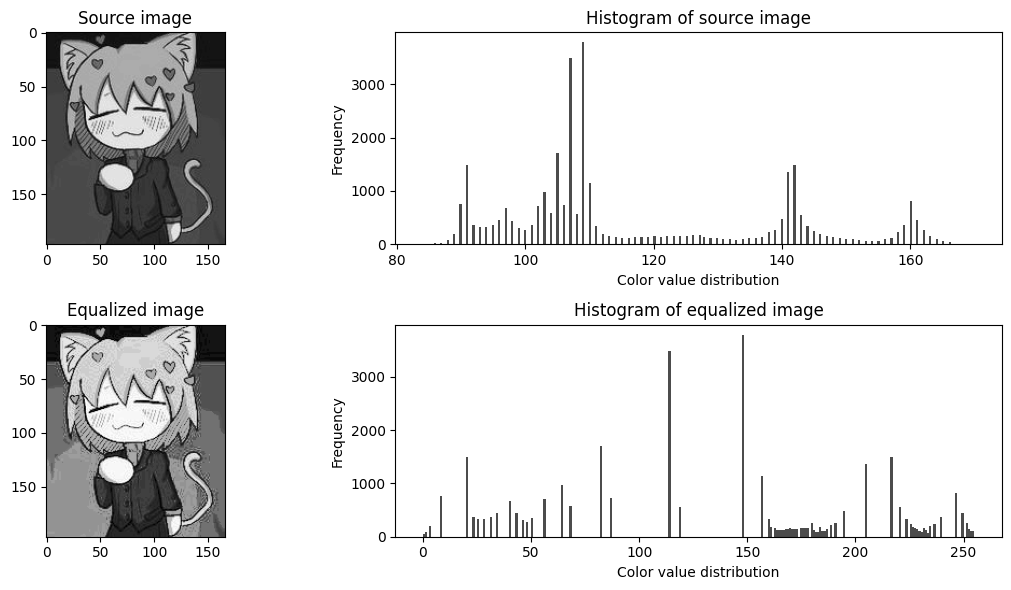

In [22]:
# Histogram Equalization
image = cv2.imread("/content/sample_data/cat_norm.jpg", cv2.IMREAD_GRAYSCALE)

equalizedImage = cv2.equalizeHist(image) # maybe need own realization

# Plots
plt.figure(figsize=(12, 6))

plt.subplot(2, 2, 1)
plt.imshow(image, 'gray')
plt.title('Source image')
plt.subplot(2, 2, 2)
plt.hist(image.ravel(), bins=256, color='black', alpha=0.7)
plt.xlabel('Color value distribution')
plt.ylabel('Frequency')
plt.title('Histogram of source image')

plt.subplot(2, 2, 3)
plt.imshow(equalizedImage, 'gray')
plt.title('Equalized image')
plt.subplot(2, 2, 4)
plt.hist(equalizedImage.ravel(), bins=256, color='black', alpha=0.7)
plt.xlabel('Color value distribution')
plt.ylabel('Frequency')
plt.title('Histogram of equalized image')

plt.tight_layout()
plt.show()